In [1]:
!pip install datasets torchvision torch scikit-learn matplotlib

In [2]:
# --- CELL 1: SETUP, LIBRARIES, AND DATA LOADING ---

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import random
import os
from PIL import Image
from google.colab import files

# 1. Reproducibility (Seeding)
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

# 2. Check Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Device: {DEVICE}")

# 3. Hyperparameters
BATCH_SIZE = 32
NUM_EPOCHS = 5  # Set to 5 for final report, 1 for quick test
IMG_SIZE = 224

# 4. Download Dataset
print("⏳ Downloading dataset (this may take a moment)...")
try:
    dataset_full = load_dataset("sidd707/jewelry-design-dataset", split="train")
    split = dataset_full.train_test_split(test_size=0.2, seed=42)
    print("✅ Dataset downloaded successfully.")
except Exception as e:
    print(f"❌ Error downloading dataset: {e}")

# 5. Custom Dataset Class
class JewelryDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform
        self.label_key = 'label'
        # Auto-detect label column name
        for k in hf_dataset.features.keys():
            if k in ['category', 'class', 'labels']:
                self.label_key = k
                break

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image'].convert('RGB')
        label = item[self.label_key]
        if self.transform:
            image = self.transform(image)
        return image, label

# 6. Transforms (Preprocessing)
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 7. Data Loaders
train_loader = DataLoader(JewelryDataset(split['train'], transform), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(JewelryDataset(split['test'], transform), batch_size=BATCH_SIZE, shuffle=False)
NUM_CLASSES = 5
print(f"✅ Data Loaders ready. Classes: {NUM_CLASSES}")

✅ Device: cuda
⏳ Downloading dataset (this may take a moment)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

dataset.zip:   0%|          | 0.00/406M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6157 [00:00<?, ? examples/s]

✅ Dataset downloaded successfully.
✅ Data Loaders ready. Classes: 5


In [3]:
# --- CELL 2: MODEL DEFINITIONS AND TRAINING ENGINE ---

def get_model(model_name):
    """Initializes the model and modifies the last layer for 5 classes."""
    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        # Modify Classifier for VGG
        model.classifier[6] = nn.Linear(4096, NUM_CLASSES)
    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        # Modify Fully Connected layer for ResNet
        model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
    return model.to(DEVICE)

def train_engine(model_name):
    """Main training loop."""
    model = get_model(model_name)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001) # Learning Rate

    print(f"\n🚀 Starting Training: {model_name}...")
    model.train()
    loss_history = []

    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            # --- Forward & Backward Pass ---
            optimizer.zero_grad()
            outputs = model(images)           # Forward Pass
            loss = criterion(outputs, labels) # Calculate Loss
            loss.backward()                   # Backward Pass (Gradient calculation)
            optimizer.step()                  # Update Weights

            running_loss += loss.item()

            if (i+1) % 20 == 0:
                print(f"\rEpoch {epoch+1} | Batch {i+1} | Loss: {loss.item():.4f}", end="")

        avg_loss = running_loss / len(train_loader)
        loss_history.append(avg_loss)
        print(f"\n✅ Epoch {epoch+1} Completed. Avg Loss: {avg_loss:.4f}")

    return model, loss_history

--- Phase 1: Training VGG-16 (Baseline) ---


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:06<00:00, 87.5MB/s]



🚀 Starting Training: vgg16...


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1 | Batch 140 | Loss: 0.1255
✅ Epoch 1 Completed. Avg Loss: 0.2305
Epoch 2 | Batch 140 | Loss: 0.1117
✅ Epoch 2 Completed. Avg Loss: 0.1009
Epoch 3 | Batch 140 | Loss: 0.0259
✅ Epoch 3 Completed. Avg Loss: 0.0763
Epoch 4 | Batch 140 | Loss: 0.0699
✅ Epoch 4 Completed. Avg Loss: 0.0538
Epoch 5 | Batch 140 | Loss: 0.0395
✅ Epoch 5 Completed. Avg Loss: 0.0281

--- Phase 2: Training ResNet-50 (Proposed Method) ---


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s]



🚀 Starting Training: resnet50...
Epoch 1 | Batch 140 | Loss: 0.1274
✅ Epoch 1 Completed. Avg Loss: 0.1937
Epoch 2 | Batch 140 | Loss: 0.0762
✅ Epoch 2 Completed. Avg Loss: 0.0706
Epoch 3 | Batch 140 | Loss: 0.1414
✅ Epoch 3 Completed. Avg Loss: 0.0362
Epoch 4 | Batch 140 | Loss: 0.0054
✅ Epoch 4 Completed. Avg Loss: 0.0420
Epoch 5 | Batch 140 | Loss: 0.1647
✅ Epoch 5 Completed. Avg Loss: 0.0220


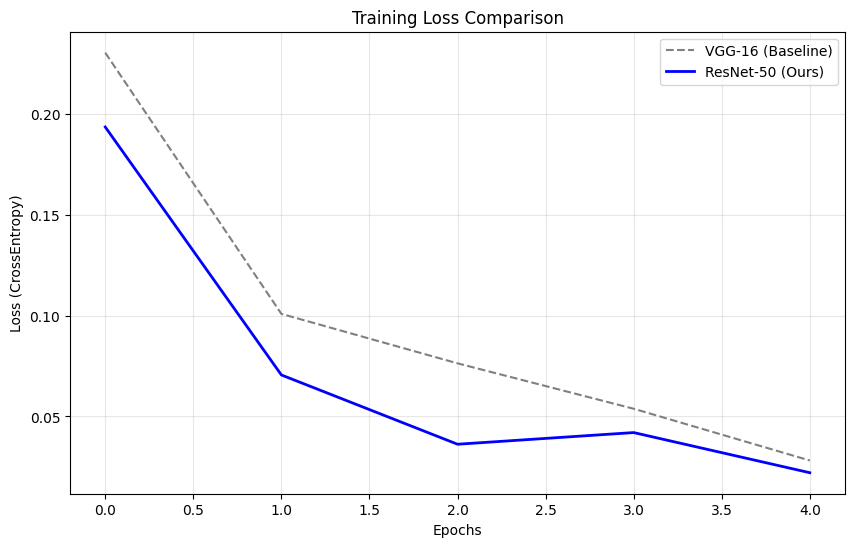


🏗 Building Feature Database (Indexing)...
Processing batch 31/39
✅ Database Indexed successfully. Ready for search.


In [4]:
# --- CELL 3: TRAINING EXECUTION AND DATABASE INDEXING ---

# 1. Train VGG-16 (Baseline)
print("--- Phase 1: Training VGG-16 (Baseline) ---")
_, vgg_losses = train_engine('vgg16')

# 2. Train ResNet-50 (Main Model)
print("\n--- Phase 2: Training ResNet-50 (Proposed Method) ---")
resnet_model, resnet_losses = train_engine('resnet50')

# 3. Plot Training Curves
plt.figure(figsize=(10, 6))
plt.plot(vgg_losses, label='VGG-16 (Baseline)', linestyle='--', color='gray')
plt.plot(resnet_losses, label='ResNet-50 (Ours)', linewidth=2, color='blue')
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss (CrossEntropy)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 4. Build Image Retrieval Database (Indexing)
print("\n🏗 Building Feature Database (Indexing)...")
resnet_model.eval()
resnet_model.fc = nn.Identity() # Remove classification head to extract features

db_features = []
db_images = []

with torch.no_grad():
    for i, (imgs, _) in enumerate(val_loader):
        imgs = imgs.to(DEVICE)
        features = resnet_model(imgs)
        db_features.append(features.cpu().numpy())
        db_images.append(imgs.cpu())
        if i % 10 == 0:
            print(f"\rProcessing batch {i+1}/{len(val_loader)}", end="")

db_features = np.vstack(db_features)
db_images = torch.cat(db_images)
print("\n✅ Database Indexed successfully. Ready for search.")

In [ ]:
# --- CELL 4: IMAGE RETRIEVAL DEMO ---
# Run this cell, click "Choose Files", and upload a jewelry image.

print("📤 UPLOAD IMAGE FOR SEARCH:")
uploaded = files.upload()

for fn in uploaded.keys():
    # 1. Display Query Image
    path = fn
    img = Image.open(path).convert('RGB')

    plt.figure(figsize=(2, 2))
    plt.imshow(img)
    plt.title("QUERY IMAGE")
    plt.axis('off')
    plt.show()

    # 2. Preprocess and Extract Features (Inference)
    img_t = transform(img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        query_vector = resnet_model(img_t).cpu().numpy()

    # 3. Compute Similarity (Cosine Distance)
    similarity_scores = cosine_similarity(query_vector, db_features)

    # 4. Retrieve Top 5 Matches
    # We sort descending. We use [0:5] assuming the query is new (not in DB).
    top_indices = similarity_scores[0].argsort()[-6:][::-1]

    # 5. Visualize Results
    print(f"\n🔍 Top Retrieval Results:")
    plt.figure(figsize=(15, 5))

    for i, idx in enumerate(top_indices[0:5]):
        plt.subplot(1, 6, i + 1)

        # De-normalize tensor for display
        res_img = db_images[idx].permute(1, 2, 0).numpy()
        res_img = res_img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        res_img = np.clip(res_img, 0, 1)

        score = similarity_scores[0][idx]
        plt.imshow(res_img)
        plt.title(f"Rank #{i+1}\nSim: {score:.2f}")
        plt.axis('off')

    plt.show()

📤 UPLOAD IMAGE FOR SEARCH:
